In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import load_model

Using TensorFlow backend.


In [3]:
spark = SparkSession.builder.master("local") \
        .appName("DLBookRecommend") \
        .config("spark.executor.memory","4g") \
        .getOrCreate()

In [4]:
ratings = spark.read.format("csv").option("header","true")\
            .option("inferschema","true") \
            .load("data/ratings_with_header.csv")

In [5]:
trainingBookData, testBookData = ratings.randomSplit([0.8, 0.2], seed = 12345)

In [8]:
print("Number of records in complete ratings dataset is {}".format(ratings.count()))
print("Number of records in training dataset is {}".format(trainingBookData.count()))
print("Number of records in test dataset is {}".format(testBookData.count()))

Number of records in complete ratings dataset is 5976479
Number of records in training dataset is 4781307
Number of records in test dataset is 1195172


In [6]:
print(ratings.columns)

['user_id', 'book_id', 'rating']


In [7]:
X_train = np.array(trainingBookData.select('user_id','book_id').collect())
Y_train = np.array(trainingBookData.select('rating').collect())

X_test = np.array(testBookData.select('user_id','book_id').collect())
Y_test = np.array(testBookData.select('rating').collect())

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(4781307, 2)
(4781307, 1)
(1195172, 2)
(1195172, 1)


##### Changing ratings from integers to categorical values

In [17]:
Y_train_cat = keras.utils.to_categorical(Y_train)
Y_test_cat = keras.utils.to_categorical(Y_test)

In [18]:
print(Y_train_cat.shape)
print(Y_test_cat.shape)

(4781307, 6)
(1195172, 6)


#### Train a model. Skip to load model if model already exists

In [21]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(Y_train_cat.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
accuracy_history = model.fit(X_train, Y_train_cat, epochs=20, batch_size=32)

Epoch 1/20
4781190/4781190 [==============================] - 120s 25us/step - loss: 1.7415 - acc: 0.3530
Epoch 2/20
4781190/4781190 [==============================] - 119s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 3/20
4781190/4781190 [==============================] - 117s 24us/step - loss: 1.3211 - acc: 0.3579
Epoch 4/20
4781190/4781190 [==============================] - 119s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 5/20
4781190/4781190 [==============================] - 120s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 6/20
4781190/4781190 [==============================] - 122s 26us/step - loss: 1.3211 - acc: 0.3579
Epoch 7/20
4781190/4781190 [==============================] - 121s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 8/20
4781190/4781190 [==============================] - 121s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 9/20
4781190/4781190 [==============================] - 121s 25us/step - loss: 1.3211 - acc: 0.3579
Epoch 10/20
1997568/4781190 [===========>.....

KeyboardInterrupt: 

In [19]:
model.save('my_model.h5')

KeyError: 'Cannot set attribute. Group with name "keras_version" exists.'

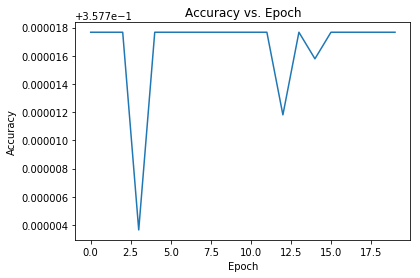

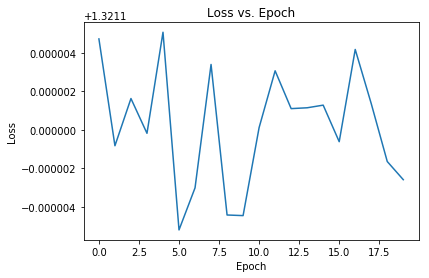

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(accuracy_history.history['acc'])
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(accuracy_history.history['loss'])
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
print(X_test.shape)
score = model.evaluate(X_test, Y_test_cat, batch_size=32)
accuracy_rate = score[1]*100
print('test accuracy is {}%'.format(round(accuracy_rate,2)))

(1195172, 2)
1195172/1195172 [==============================] - 10s 8us/step
test accuracy is 35.87%


#### Loading a Model

In [3]:
model = keras.models.load_model('my_model.h5')

##### How to get predicted rating for a given userId and bookId

In [4]:
sampleUserId = 100
sampleBookId = 3753
sampleX = np.array([[sampleUserId, sampleBookId]])
pred = model.predict_classes(sampleX)

print("Predicted rating was ---->",pred)

Predicted rating was ----> [4]
